### load necessary modules

In [49]:
#env: lpr
# adopted from: https://github.com/StephenChao/boostedHWW/blob/a9dd3a9fe21657d2d103bfb2191271a8894c1865/scale_factors/LundReweighting/calibration_ParT_tagger_H4q3qlvqq.ipynb

In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import awkward as ak
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)
import sys



In [3]:
MAIN_DIR = "."
sample = "ggF"
data_points = []
year = "2018"
plot_dir = f"{MAIN_DIR}/plots/test_EGM/21Jun2024"
_ = os.system(f"mkdir -p {plot_dir}")

### Load signal NanoAOD files and do pre-selection 

In [4]:
isData = True if sample == "Data" else False
samples = {
    "ggF" : "/data/bond/zhaoyz/Ntuple/EGM_test/merged/ggF/ggF.root",
    "VBF" : "/data/bond/zhaoyz/Ntuple/EGM_test/merged/ggF/VBF.root",
    "Data": "/data/bond/zhaoyz/Ntuple/EGM_test/merged/2018A/2018A.root",
    "QCD" : "/data/bond/zhaoyz/Ntuple/EGM_test/merged/QCD/QCD.root",
}
# #first way to load root file is using nanoevents, but suffer from low process speed
events = nanoevents.NanoEventsFactory.from_root(
        samples[sample],
        # "/data/bond/zhaoyz/Ntuple/EGM_test/merged/ggF/ggF.root",
        # "/data/bond/zhaoyz/Ntuple/EGM_test/merged/ggF/VBF.root", #from Summer20UL18 ggF(with H pT>200 cut) samples, already vetoed muon
        # "/data/bond/zhaoyz/Ntuple/EGM_test/merged/2018A/2018A.root", #random ~1M events from 2018A JetHT primary dataset, already vetoed muon
        # "/data/bond/zhaoyz/Ntuple/EGM_test/merged/QCD/QCD.root", #from Summer20UL18 QCD HT1000to1500 samples, already vetoed muon
        schemaclass=nanoevents.NanoAODSchema,
    ).events()
#second way to load root file is using uproot.lazy
# events = uproot.lazy({"/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root":"Events"})


/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:208: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:208: RuntimeWarning: Missing cross-reference target for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:208: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet

In [5]:
events

<NanoEventsArray [<event 1:271:270008>, ... ] type='31085 * event'>

In [6]:
if isData == True:
    desired_fields = ["Electron","Muon","FatJet"]
else: 
    desired_fields = ["Electron","Muon","FatJet","genWeight"]
filtered_events = events[desired_fields]

In [7]:
filtered_events

<Array [{Electron: [, ... genWeight: 0.472}] type='31085 * {"Electron": var * el...'>

In [8]:
filtered_events.fields

['Electron', 'Muon', 'FatJet', 'genWeight']

### Define necessary functions to run the selection

In [9]:
#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )


In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


In [11]:
#pre-selection:
#1.Leading jet pT > 400GeV, maximum jet mass > 50GeV
#2.Require 2 or 3 AK8 jet with pT > 200GeV
#3.Veto (mini-)Isolated leptons
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
preselection_cut_vals = {"pt": 200, "msd": 20, "leading_pt":400,"maximum_mass":50}
num_jets = 2

# fatjets = corrections.get_jec_jets(events, "2018")
fatjets = filtered_events.FatJet

preselection_cut_1 = pad_val(
        ( ak.max(filtered_events.FatJet.pt, axis = 1) > preselection_cut_vals["leading_pt"])
        * (ak.max(filtered_events.FatJet.msoftdrop, axis = 1) > preselection_cut_vals["maximum_mass"]), #mass and pT cut of each jet in event
        len(events), #pad to num_jets length
        False,  #pad with value False
        )
# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "leading pT and maximum mass", #string name
    preselection_cut_1.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)



preselection_cut_2 = np.prod(
    pad_val(
        (filtered_events.FatJet.pt > preselection_cut_vals["pt"]),
        # * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]), #mass and pT cut of each jet in event
        num_jets, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "at least 2 AK8 jet with pT >200GeV", #string name
    preselection_cut_2.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

preselection_cut_3 = pad_val(
        (ak.num(filtered_events.FatJet.pt) == 2) | (ak.num(filtered_events.FatJet.pt) == 3) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "2 or 3 AK8 jet", #string name
    preselection_cut_3.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [12]:
cutflow

{'all': 31075,
 'leading pT and maximum mass': 29950.0,
 'at least 2 AK8 jet with pT >200GeV': 29948.0,
 '2 or 3 AK8 jet': 29184.0}

In [13]:
# derive events after the kinematic selection
filtered_events = filtered_events[selection.all(*selection.names)]

In [14]:
filtered_events

<Array [{Electron: [, ... genWeight: 0.472}] type='29194 * {"Electron": var * el...'>

### plot the electron pT spectrum

In [15]:
# ak.max(ak.num(filtered_events.Electron))

In [16]:
# filtered_events.Electron.pt

In [17]:
# ele_pt_filtered_unflt = filtered_events.Electron.pt[ak.num(filtered_events.Electron.pt, axis = 1)>0]

In [18]:
# ele_pt_filtered_unflt

In [19]:
# ele_pt_filtered = ak.flatten(ele_pt_filtered_unflt,axis = 1)

In [20]:
# nbins = 20
# x_min = 0
# x_max = 200
# legend_location='upper left'
# plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
# # plt.figure(figsize=(14,10))
# f = plt.figure(figsize=(14, 15))
# gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
# ax = f.add_subplot(gs[0])
# plt.grid()
# LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
# hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
# ax1 = f.add_subplot(gs[1])
# ax1.grid()

# hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
# hist_region.fill(ele_pt_filtered)
# hist_value_up = flow(hist_region)[0]
# hist_var_up   = flow(hist_region)[1]
# err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
# hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JES,total up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

# ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
# ax.set_ylabel("Events")
# ax1.set_ylabel("ratio")
# ax1.set_ylim(0, 2)
# # ax.set_yscale('log') 
# ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
# ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
# # plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
# plt.savefig(f"{plot_dir}/ele_pT_{year}.pdf", bbox_inches='tight')    


In [21]:
#define good/loose electron, but without pT selection because we want to see the pT distribution
electrons = filtered_events.Electron

loose_electrons_wo_pt = (
    (np.abs(electrons.eta) < 2.5)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    # & (electrons.cutBased >= 2)
    & (electrons.mvaFall17V2noIso_WPL)
    # & (electrons.cutBased >= electrons.LOOSE) #cut-based ID Fall17 V2 (0:fail, 1:veto, 2:loose, 3:medium, 4:tight)
)

good_electrons_wo_pt = (
    (np.abs(electrons.eta) < 2.5)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
)

In [22]:
loose_electrons_wo_pt

<Array [[False], [False, False, ... [], []] type='29194 * var * bool'>

In [23]:
good_ele_pt_unflt = electrons[good_electrons_wo_pt].pt
good_ele_pt = ak.flatten(good_ele_pt_unflt[ak.num(good_ele_pt_unflt, axis = 1) > 0], axis= 1)

loose_ele_pt_unflt = electrons[loose_electrons_wo_pt].pt
loose_ele_pt = ak.flatten(loose_ele_pt_unflt[ak.num(loose_ele_pt_unflt, axis = 1) > 0], axis= 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


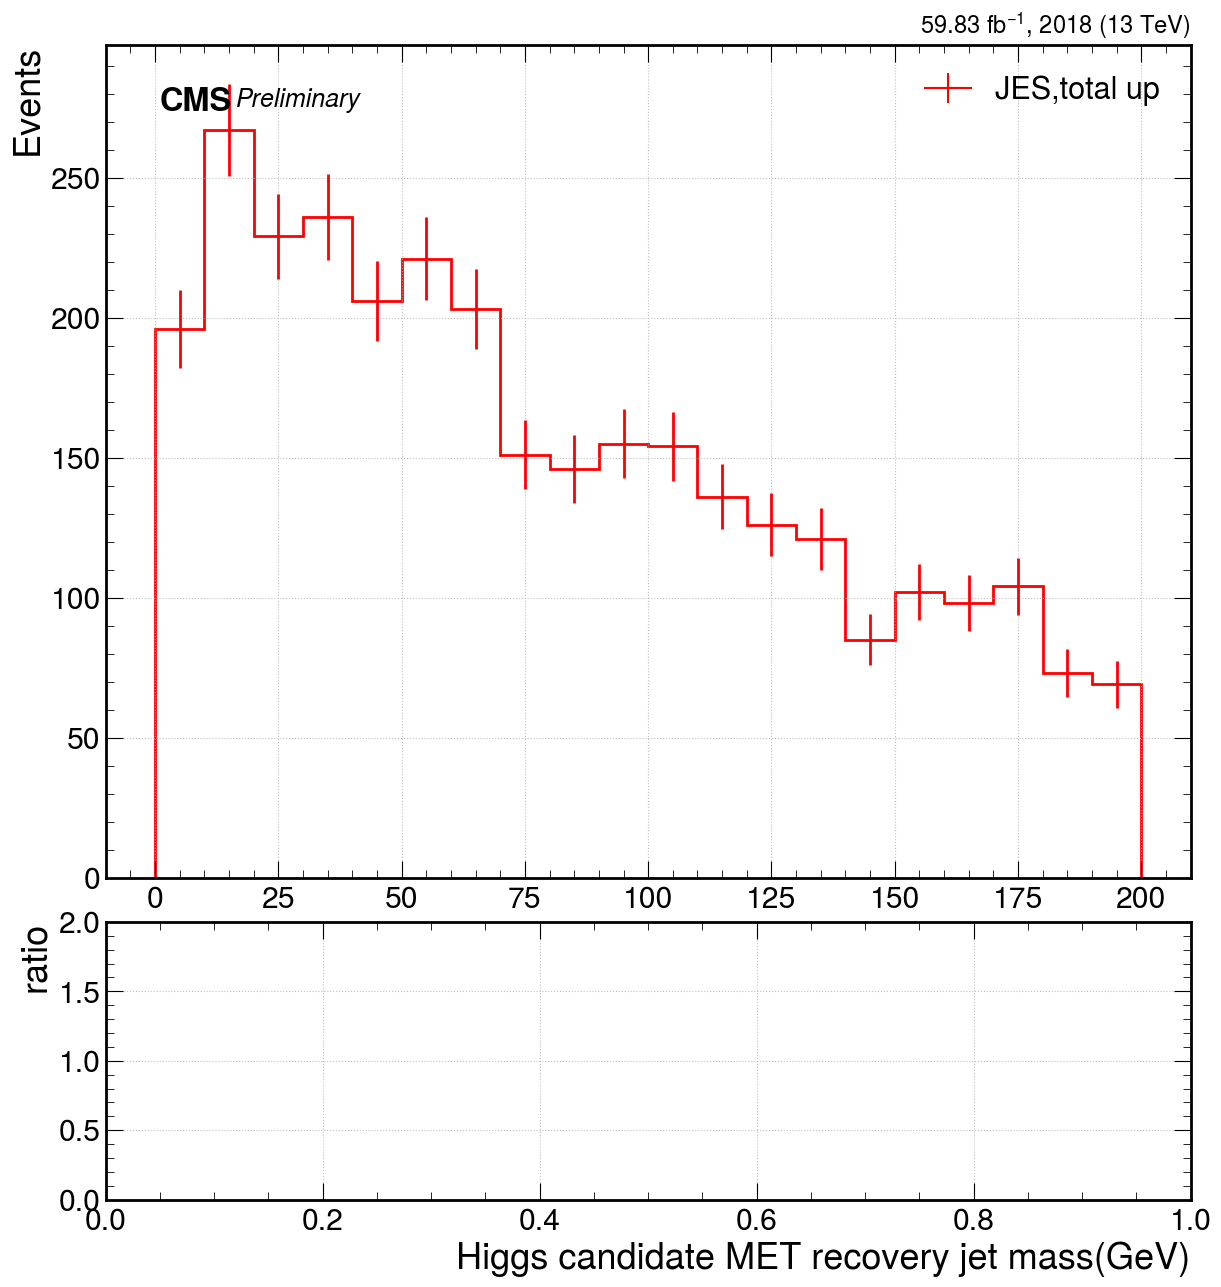

In [24]:
# plot good ele pT distribution
nbins = 20
x_min = 0
x_max = 200
legend_location='upper left'
plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
# plt.figure(figsize=(14,10))
f = plt.figure(figsize=(14, 15))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
ax = f.add_subplot(gs[0])
plt.grid()
LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
ax1 = f.add_subplot(gs[1])
ax1.grid()

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_region.fill(good_ele_pt)
hist_value_up = flow(hist_region)[0]
hist_var_up   = flow(hist_region)[1]
err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JES,total up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
ax.set_ylabel("Events")
ax1.set_ylabel("ratio")
ax1.set_ylim(0, 2)
# ax.set_yscale('log') 
ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
# plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
plt.savefig(f"{plot_dir}/ele_pT_{year}.pdf", bbox_inches='tight')    


In [25]:
electrons.pt >= 30

<Array [[True], [True, False, ... [], []] type='29194 * var * bool'>

In [31]:
(electrons.pt >= 30) & (electrons.pfRelIso03_all < 0.25) | (electrons.pt >= 120)

<Array [[False], [False, False, ... [], []] type='29194 * var * bool'>

In [26]:
loose_electrons_wo_pt

<Array [[False], [False, False, ... [], []] type='29194 * var * bool'>

In [27]:
(electrons.pt >= 30) & loose_electrons_wo_pt

<Array [[False], [False, False, ... [], []] type='29194 * var * bool'>

In [28]:
pT_cut = ak.Array(range(0,100,4))

In [29]:
pT_cut

<Array [0, 4, 8, 12, 16, ... 84, 88, 92, 96] type='25 * int64'>

In [44]:
# get loose efficiency distribution
efficiency_loose = []
for pT_cut in range(0,100,4):
    print("pT_cut:", pT_cut)
    cut_arr = ((electrons.pt >= pT_cut) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt >= 120)
    complete_loose_ele = (cut_arr & loose_electrons_wo_pt) #pT cut * definition discarding pT cut
    num_complete_loose_ele = ak.sum(complete_loose_ele, axis = 1)
    #num = events number after veto, denom = total event numer
    efficiency_i = (len(num_complete_loose_ele) - ak.sum(num_complete_loose_ele != 0))/len(num_complete_loose_ele)
    efficiency_loose.append(efficiency_i)
    print("efficiency:",efficiency_i)
efficiency_loose = ak.Array(efficiency_loose)

pT_cut: 0
efficiency: 0.865725834075495
pT_cut: 4
efficiency: 0.865725834075495
pT_cut: 8
efficiency: 0.8686716448585325
pT_cut: 12
efficiency: 0.8720284990066453
pT_cut: 16
efficiency: 0.8750428170171953
pT_cut: 20
efficiency: 0.8783311639377954
pT_cut: 24
efficiency: 0.8811742138795643
pT_cut: 28
efficiency: 0.8842570391176269
pT_cut: 32
efficiency: 0.8873056107419333
pT_cut: 36
efficiency: 0.8904911968212647
pT_cut: 40
efficiency: 0.893402753990546
pT_cut: 44
efficiency: 0.8960402822497774
pT_cut: 48
efficiency: 0.8986435568952524
pT_cut: 52
efficiency: 0.9007330273343838
pT_cut: 56
efficiency: 0.9027882441597589
pT_cut: 60
efficiency: 0.9052545043502089
pT_cut: 64
efficiency: 0.9073097211755841
pT_cut: 68
efficiency: 0.9090566554771529
pT_cut: 72
efficiency: 0.9108720970062342
pT_cut: 76
efficiency: 0.9123107487839968
pT_cut: 80
efficiency: 0.9136466397204905
pT_cut: 84
efficiency: 0.915359320408303
pT_cut: 88
efficiency: 0.9164896896622594
pT_cut: 92
efficiency: 0.9177570733712407

/tmp/ipykernel_2574928/3808210093.py:34: RuntimeWarning: invalid value encountered in true_divide
  number = h**2 / var
/tmp/ipykernel_2574928/3808210093.py:51: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= var/h
/tmp/ipykernel_2574928/3808210093.py:52: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= var/h


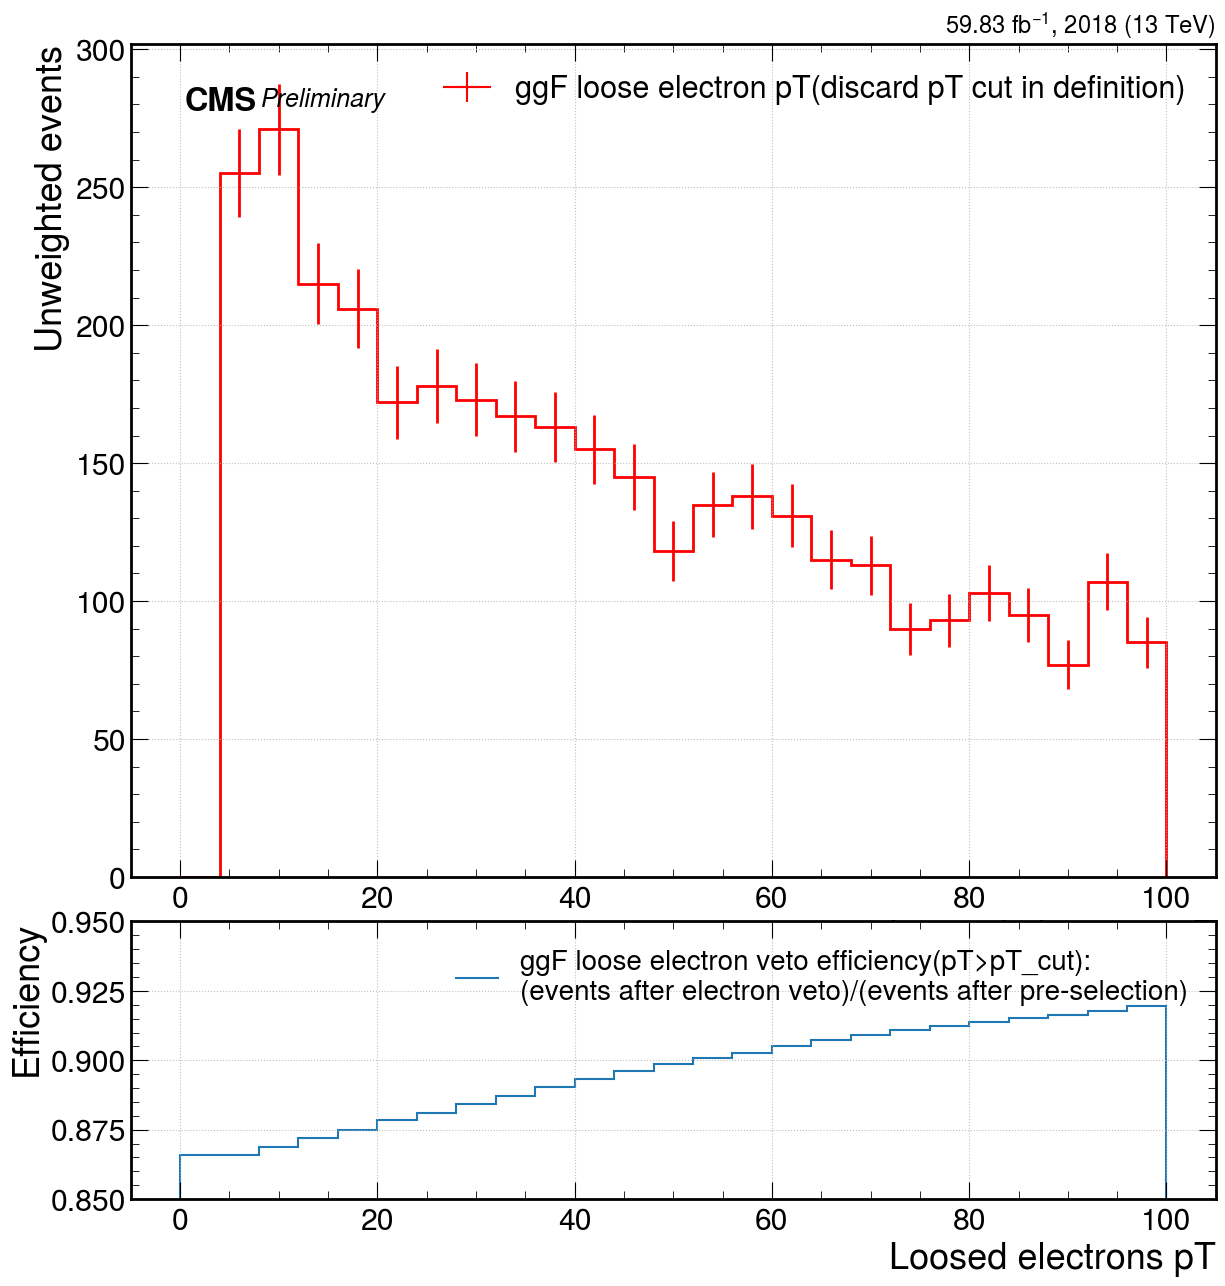

In [43]:
# plot loose ele distribution
nbins = 25
x_min = 0
x_max = 100
legend_location='upper left'
plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
# plt.figure(figsize=(14,10))
f = plt.figure(figsize=(14, 15))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
ax = f.add_subplot(gs[0])
plt.grid()
LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
ax1 = f.add_subplot(gs[1])
ax1.grid()

#plot pT distribution first
hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_region.fill(loose_ele_pt)
hist_value_up = flow(hist_region)[0]
hist_var_up   = flow(hist_region)[1]
err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label=f"{sample} loose electron pT(discard pT cut in definition)", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

#then plot pT cut efficiency
hep.histplot(efficiency, bins=hist_region.axes[0].edges,ax = ax1, label=f"{sample} loose electron veto efficiency(pT>pT_cut):\n(events after electron veto)/(events after pre-selection)")

ax.set_xlabel("Loosed electrons pT")
ax.set_ylabel("Unweighted events")

ax1.set_xlabel("Loosed electrons pT")
ax1.set_ylabel("Efficiency")

ax1.set_ylim(0.85, 0.95)
# ax.set_yscale('log') 
ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
# plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
plt.savefig(f"{plot_dir}/loose_ele_pT_{year}_{sample}.pdf", bbox_inches='tight')    


In [78]:
# data_points.append(cutflow["all"])


In [ ]:
# filtered_events = filtered_events[selection.all(*selection.names)]
# events = nanoevents.NanoEventsFactory.from_events(events[selection.all(*selection.names)])


In [ ]:
# eventsScoreFatjet = filtered_events
# tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
# leading_tagger = np.max(tagger_scores,axis = 1)

In [ ]:
# selection = PackedSelection() #initialize a new object
# signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
# n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
# selection = PackedSelection() #initialize a new object

# cutflow = {}
# # cutflow["all"] = len(events) #shouldn't be n_events?
# cutflow["all"] = n_events

# preselection_cut_tag = pad_val(
#         (leading_tagger >= 0.9) , #mass and pT cut of each jet in event
#         len(filtered_events), #pad to num_jets length
#         False,  #pad with value False
#         )

# add_selection(
#     "tagger cut", #string name
#     preselection_cut_tag.astype(bool), #selection content
#     selection, #PackedSelection object
#     cutflow, #cut-flow dict, storing events number after each cut
#     isData,
#     signGenWeights,#sum the signGenWeights for events which pass the selection
# )


In [ ]:
# cutflow

In [ ]:
# filtered_events = filtered_events[selection.all(*selection.names)]

In [97]:
selection = PackedSelection() #initialize a new object
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events

#veto (mini-)isolated muons
#referring to : https://github.com/farakiko/boostedhiggs/blob/ec53b97857bf64aa4d75f639e290181e65a55b4c/boostedhiggs/hwwprocessor.py#L185-L237
muons = ak.with_field(filtered_events.Muon, 0, "flavor")
electrons = ak.with_field(filtered_events.Electron, 1, "flavor")

# muons: already required when doing ntuple files
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)

n_loose_muons = ak.sum(loose_muons, axis=1)
good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)


# electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.5)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    # & (electrons.cutBased >= 2)
    & (electrons.mvaFall17V2noIso_WPL)
    # & (electrons.cutBased >= electrons.LOOSE) #cut-based ID Fall17 V2 (0:fail, 1:veto, 2:loose, 3:medium, 4:tight)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)
good_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.15)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.5)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# n_leptons = n_loose_electrons + n_good_electrons + n_loose_muons + n_good_muons
n_leptons = n_loose_electrons + n_good_electrons 

preselection_cut_4 = pad_val(
        (n_leptons == 0) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "no (mini-)isolated leptons", #string name
    preselection_cut_4.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [98]:
cutflow

{'all': 29184, 'no (mini-)isolated leptons': 26038.0}

In [99]:
data_points.append(cutflow["all"])
data_points.append(cutflow["no (mini-)isolated leptons"])

In [100]:
electron_eff =  (cutflow["all"] - cutflow['no (mini-)isolated leptons'])/cutflow["all"]

In [101]:
electron_eff

0.10779879385964912

In [ ]:
#making plots:

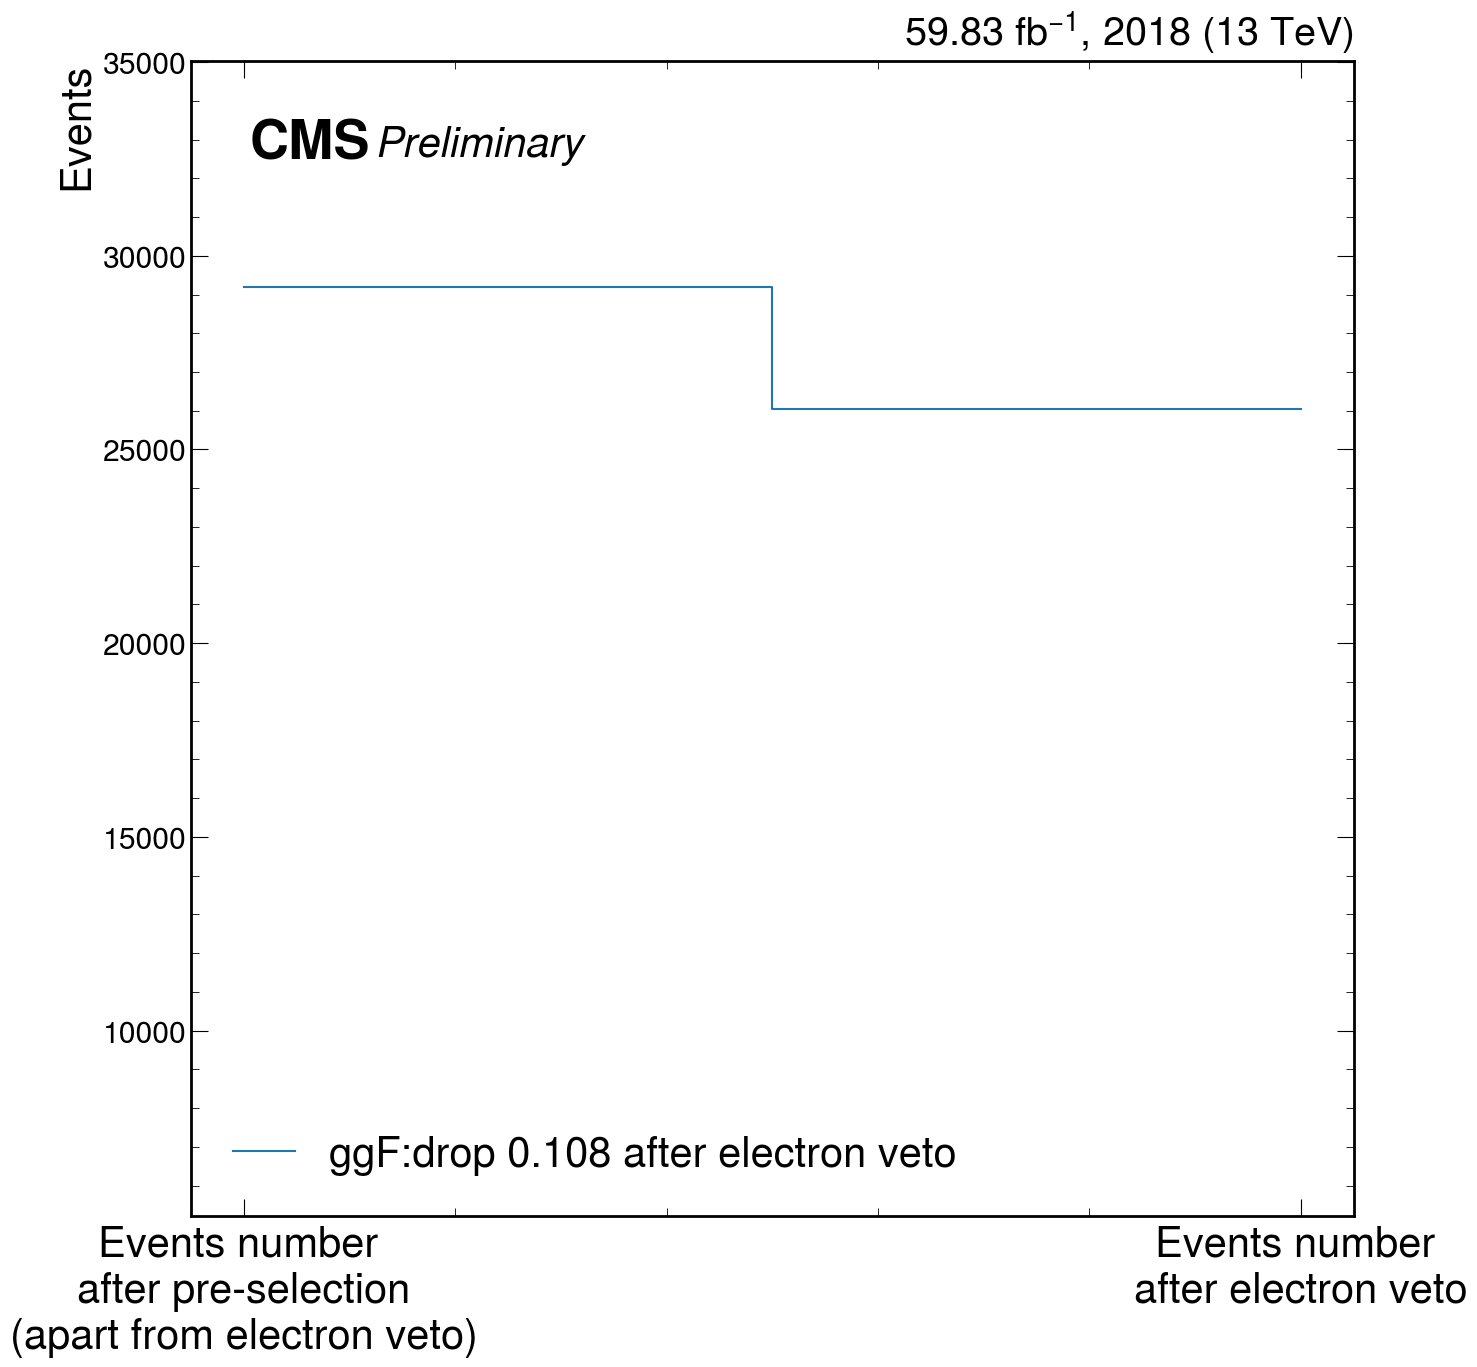

In [102]:
import matplotlib.pyplot as plt
import mplhep as hep

# 数据点和标签
labels = ['Events number \nafter pre-selection\n(apart from electron veto)', "Events number \nafter electron veto"]


# 创建阶梯状图
LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
fig, ax = plt.subplots(figsize = (15,15))
ax.step(range(len(data_points)), data_points, where='mid', label=f"{sample}:drop {str(round(electron_eff,3))} after electron veto")
# ax.step(range(len(data_points)), data_points, where='mid')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize = 30)
hep.cms.label(loc = 1, data=isData, year=year, ax=ax, lumi=LUMI[year], fontsize=30, llabel='Preliminary')
# ax.set_xticklabels(labels, fontsize=14, ha='center', va='top', rotation=0, linespacing=1.5)

# for i in range(len(data_points)):
#     ax.text(i, data_points[i], labels[i], ha='center', va='bottom')

# 添加标签和标题
# ax.set_xlabel('Labels')
ax.set_ylim(data_points[-1]*0.2,data_points[0]*1.2)
ax.set_ylabel('Events',fontsize = 30)
# ax.set_title('Events number after each cut',fontsize = 30)
ax.legend(loc = "lower left",fontsize = 30)

# 如果你想使用HEP样式
hep.style.use("CMS")
plt.savefig(f"{plot_dir}/{sample}.pdf")
# 显示图形
plt.show()
